In [1]:
%load_ext autoreload
%autoreload 2

import os
import json
import copy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import ray_results_interpreter as rri
import subprocess
import concurrent.futures
from main_run import MainRun

/user/ml4723/.conda/envs/neural_inventory_control/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/user/ml4723/.conda/envs/neural_inventory_control/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# Lower bound values for different numbers of stores
# 3: 8.533673716946652
# 5: 7.902133198919353
# 10: 8.296968310182638
# 20: 8.731082080524004
# underage costs = tensor(2.1198, dtype=torch.float64)
# holding costs = tensor(6.6113, dtype=torch.float64)

# 30: 8.37732777290095
# 50: 8.118102268777966

# Create vanilla results dataframe from the provided data
testset_name = "finals_transshipment"

results_interpretor = rri.RayResultsinterpreter()

def custom_data_filler(out_row, reference_row):
    out_row['path'] = reference_row['path']

def default_condition_setter(condition_name):
    return None

# Define color scheme, line styles and markers
color_scheme = {
    128: "#1f77b4",    # Blue
    1024: "#2ca02c",   # Green  
    8192: "#ff7f0e",   # Orange
}

marker_scheme = {
    128: "o",          # Circle
    1024: "v",         # Down triangle
    8192: "s",         # Square
}

linestyle_scheme = {
    "Vanilla NN": "-",  # Dashed
    "GNN": "--",         # Solid
}
# Define paths for each architecture
# Define architectures with their path patterns
architectures = {
    "Vanilla NN": lambda n: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/vanilla_transshipment_50',
    "GNN": lambda n: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/GNN_transshipment_50',
}

sort_by = 'dev_loss'
pick_row_from_run_by = 'dev_loss'

# Define number of stores and sample sizes
n_stores = [3, 5, 10, 20, 30, 50]
sample_sizes = [128, 1024, 8192]

# Store lower bounds in a dictionary for easy lookup
lower_bounds = {
    3: 8.533673716946652,
    5: 7.902133198919353,
    10: 8.296968310182638,
    20: 8.731082080524004,
    30: 8.37732777290095,
    50: 8.118102268777966,
}

dfs = []

# Create dataframes for each architecture, store size and sample size
for arch_name, path_fn in architectures.items():
    for n_store in n_stores:
        path = path_fn(n_store)
        for sample_size in sample_sizes:
            df = results_interpretor.make_table({1: path},
                {'train_dev_sample_and_batch_size': [sample_size],
                 'store_underage_cost': [9],
                 'store_lead_time': [4],
                 'samples': [1],
                 'n_stores': [n_store]},
                default_condition_setter, custom_data_filler,
                sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by,
                test_loss_limit = 100)
            if df.empty:
                continue
            
            df.insert(2, 'Architecture Class', arch_name)
            df.insert(1, 'hyperparam_name', arch_name)
            df['train_dev_sample_and_batch_size'] = sample_size
            df['n_stores'] = n_store
            dfs.append(df)
df = pd.concat(dfs, ignore_index=True)

In [6]:
import numpy as np

test_loss_column = 'Test Loss'
test_loss_filename = 'transshipment_backlogged_5000_test_loss.txt'

test_losses = []
for _, row in df.iterrows():
    test_loss_path = str(row['path']) +"/"+ test_loss_filename
    try:
        with open(test_loss_path, 'r') as f:
            value = float(f.read().strip())
    except Exception:
        value = np.nan
    test_losses.append(value)

df[test_loss_column] = test_losses

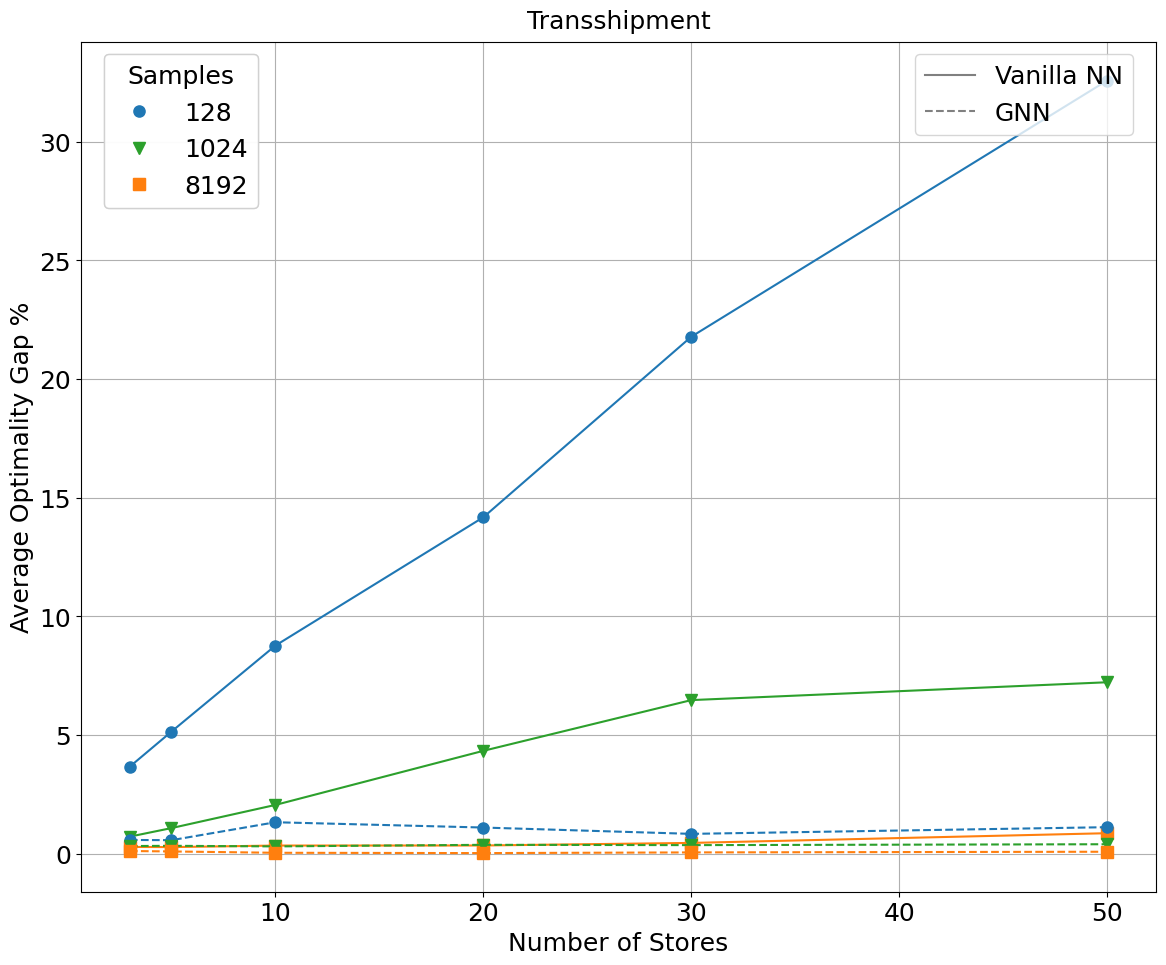

In [7]:
# Calculate optimality gap using lower bounds
stats_by_arch_sample_and_stores = {}
for n_store in n_stores:
    store_data = df[df['n_stores'] == n_store].copy()
    if store_data.empty:
        continue

    lower_bound = lower_bounds[n_store]
    store_data.loc[:, 'Optimality Gap %'] = ((store_data['Test Loss'] - lower_bound) / lower_bound) * 100

    for arch in store_data['Architecture Class'].unique():
        for sample_size in sample_sizes:
            key = (arch, sample_size)
            if key not in stats_by_arch_sample_and_stores:
                stats_by_arch_sample_and_stores[key] = []

            sample_data = store_data[(store_data['train_dev_sample_and_batch_size'] == sample_size) &
                                     (store_data['Architecture Class'] == arch)]
            if not sample_data.empty:
                gaps = sample_data['Optimality Gap %'].to_numpy()
                mean_gap = np.mean(gaps)
                stats_by_arch_sample_and_stores[key].append({
                    'n_stores': n_store,
                    'mean_gap': mean_gap
                })

FONTSIZE = 18
plt.figure(figsize=(12, 10))
plt.rcParams.update({'font.size': FONTSIZE})

for (arch, sample_size), stats in stats_by_arch_sample_and_stores.items():
    stats_df = pd.DataFrame(stats)
    if not stats_df.empty:
        n_stores_array = stats_df['n_stores'].to_numpy()
        mean_gap_array = stats_df['mean_gap'].to_numpy()

        plt.plot(n_stores_array, mean_gap_array,
                 marker=marker_scheme[sample_size],
                 color=color_scheme[sample_size],
                 linestyle=linestyle_scheme[arch],
                 markersize=8)

arch_lines = [plt.Line2D([0], [0], color='gray', linestyle=linestyle_scheme[arch], label=arch)
              for arch in linestyle_scheme.keys()]
sample_patches = [plt.Line2D([0], [0], color=color_scheme[size], marker=marker_scheme[size],
                             linestyle='none', label=f'{size}', markersize=8)
                  for size in color_scheme.keys()]

plt.xlabel('Number of Stores', fontsize=FONTSIZE)
plt.ylabel('Average Optimality Gap %', fontsize=FONTSIZE)
plt.grid(True)

legend1 = plt.legend(handles=arch_lines,
                     bbox_to_anchor=(0.99, 1),
                     loc='upper right',
                     fontsize=FONTSIZE)
plt.gca().add_artist(legend1)

legend2 = plt.legend(handles=sample_patches,
                     title='Samples',
                     bbox_to_anchor=(0.01, 1),
                     loc='upper left',
                     fontsize=FONTSIZE)
plt.gca().add_artist(legend2)
legend2.get_title().set_fontsize(FONTSIZE)

plt.xticks(fontsize=FONTSIZE)
plt.yticks(fontsize=FONTSIZE)
plt.title('Transshipment', fontsize=FONTSIZE, pad=10)
plt.tight_layout()
plt.show()

In [5]:
mode = "test"
setting_names = ['transshipment_backlogged_5000']

models = []
for _, row in df.iterrows():
    models.append(str(row['path']) + '/model.pt')

gpus = [0, 1, 2, 4, 5, 6]

def run_main_run(model_path, setting_name, gpu_idx):
    try:
        # Extract hyperparam name from model path
        hyperparam_name = model_path.split('/')[7]
        print(f"Running main_run.py for path {model_path}")
        cmd = [
            "/user/ml4723/.conda/envs/neural_inventory_control/bin/python",
            "main_run.py",
            mode, # test or test_on_dev
            setting_name,
            hyperparam_name,
            str(model_path),
            str(gpus[gpu_idx])
        ]
        env = {
            **os.environ,
            "MKL_THREADING_LAYER": "GNU",
            "MKL_SERVICE_FORCE_INTEL": "1"
        }
        subprocess.run(cmd, capture_output=True, text=True, check=True, env=env, cwd="/user/ml4723/Prj/NIC/")
    except subprocess.CalledProcessError as e:
        print(f"Error running main_run.py for path {model_path}: {e}")
        print(f"Error output: {e.stderr}")
    except Exception as e:
        print(f"Unexpected error running main_run.py for path {model_path}: {e}")

with concurrent.futures.ThreadPoolExecutor() as executor:
    futures = []
    gpu_idx = 0
    for setting_name in setting_names:
        for path in models:
            while len(futures) >= 6*len(gpus):
                done, not_done = concurrent.futures.wait(
                    futures, 
                    return_when=concurrent.futures.FIRST_COMPLETED
                )
                futures = list(not_done)
            futures.append(executor.submit(run_main_run, path, setting_name, gpu_idx))
            gpu_idx = (gpu_idx + 1) % len(gpus)
    concurrent.futures.wait(futures)


Running main_run.py for path /user/ml4723/Prj/NIC/ray_results/finals_transshipment/vanilla_transshipment_50/run_2025-05-21_11-36-07/run_5033a_00427_427_config=transshipment_backlogged,dev_ignore_periods=60,dev_periods=100,different_for_each_sample=True,early_sto_2025-05-21_13-56-35/model.pt
Running main_run.py for path /user/ml4723/Prj/NIC/ray_results/finals_transshipment/vanilla_transshipment_50/run_2025-05-21_11-36-07/run_5033a_00319_319_config=transshipment_backlogged,dev_ignore_periods=60,dev_periods=100,different_for_each_sample=True,early_sto_2025-05-21_11-39-44/model.pt
Running main_run.py for path /user/ml4723/Prj/NIC/ray_results/finals_transshipment/vanilla_transshipment_50/run_2025-05-21_11-36-07/run_5033a_00106_106_config=transshipment_backlogged,dev_ignore_periods=60,dev_periods=100,different_for_each_sample=True,early_sto_2025-05-21_11-36-12/model.pt
Running main_run.py for path /user/ml4723/Prj/NIC/ray_results/finals_transshipment/vanilla_transshipment_50/run_2025-05-21_1